# 9. Frame select gradients

In [1]:
from src import *

import warnings
warnings.filterwarnings("ignore")

## Description

We want to look at the frame selected gradients and their general properties

GOAL: Visualize frame selected gradients

## Table of Contents
- [Frame select Visualize](#single)

<a class="anchor" id="single"></a>
## Frame select Visualize

In [2]:
threshed_series = load('./resources/fa_treshed_series.pkl')

In [14]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 20
rs         = 99

# In-Tervals percentages
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

Frame selected

In [6]:
fselect_group_gradients = {}
fselect_group_expvar = {}
for i in tqdm(range(3)):
    # individual variance variables
    fselect_subjects_gradients = {}
    fselect_subjects_expvar = {}
    threshed = threshed_series[i]
    for rng in tqdm(threshed.keys()):
        selected_series = threshed[rng]

        # concatenate on different frames across movies
        # basically doing reordering of columns
        tmp = next(iter(selected_series))
        subject_numbers = list(selected_series[tmp].keys())
        subject_tmpseries = {_id:[] for _id in subject_numbers}

        for mname in selected_series:
            if len(selected_series[mname]) == 0: continue
            for _id in subject_numbers:
                subject_tmpseries[_id].append(selected_series[mname][_id])

        subject_series = []
        for _id in subject_numbers:
            subject_series.append(np.concatenate(subject_tmpseries[_id]))

        # if concatenated length not long enough then skip whole process
        if len(subject_series[0]) < 15: 
            fselect_subjects_gradients[rng] = []
            continue

        # Compute individual gradients according to selected frames
        group_series = []
        for nsub in range(len(subject_numbers)):
            tmp_series = np.asarray(subject_series)[nsub]
            group_series.append(tmp_series)
            
        fc_selects = FC(np.concatenate(group_series))
        g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                                kernel=aff_kernel, random_state=rs)
        g_selects.fit(fc_selects)

        fselect_subjects_gradients[rng] = g_selects.gradients_
        fselect_subjects_expvar[rng] = g_selects.lambdas_
    
    fselect_group_gradients[i] = fselect_subjects_gradients
    fselect_group_expvar[i] = fselect_subjects_expvar

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Films

In [7]:
total_series = load('./data/fmri_414_series.pkl')
del total_series['Rest']

allmovies_series = []
for mname in total_series:
    movie_series = total_series[mname]
    allmovies_series.append(np.concatenate(np.asarray(list(movie_series.values()))))
    
allmovies_series = np.concatenate(allmovies_series)
fc_movies = FC(allmovies_series)
g_movies = GradientMaps(n_components=nb_comp, approach=embedding, 
                        kernel=aff_kernel, random_state=rs)
g_movies.fit(fc_movies)

movies_grad = g_movies.gradients_
movies_expvar = g_movies.lambdas_

Rest

In [8]:
# Rest Gradients Computation
mri_path414 = './data/fmri414_compiled/'
rest_series  = []
mri_df414rest   = pd.read_csv(mri_path414 + "Rest_compiled414.csv")
rests  = [m for m in mri_df414rest.filename.unique() if "414" in m]
for r in rests:
    tmp2, _ = df_to_timeseries(mri_df414rest, r)
    rest_series.append(tmp2)
    

rests_series = np.concatenate(rest_series)
fc_rests = FC(rests_series)
g_rests = GradientMaps(n_components=nb_comp, approach=embedding, 
                        kernel=aff_kernel, random_state=rs)
g_rests.fit(fc_rests)

rest_grad = g_rests.gradients_
rest_expvar = g_rests.lambdas_

#### Explained variance comparisons

First comparison Rest Vs Movie Vs FS

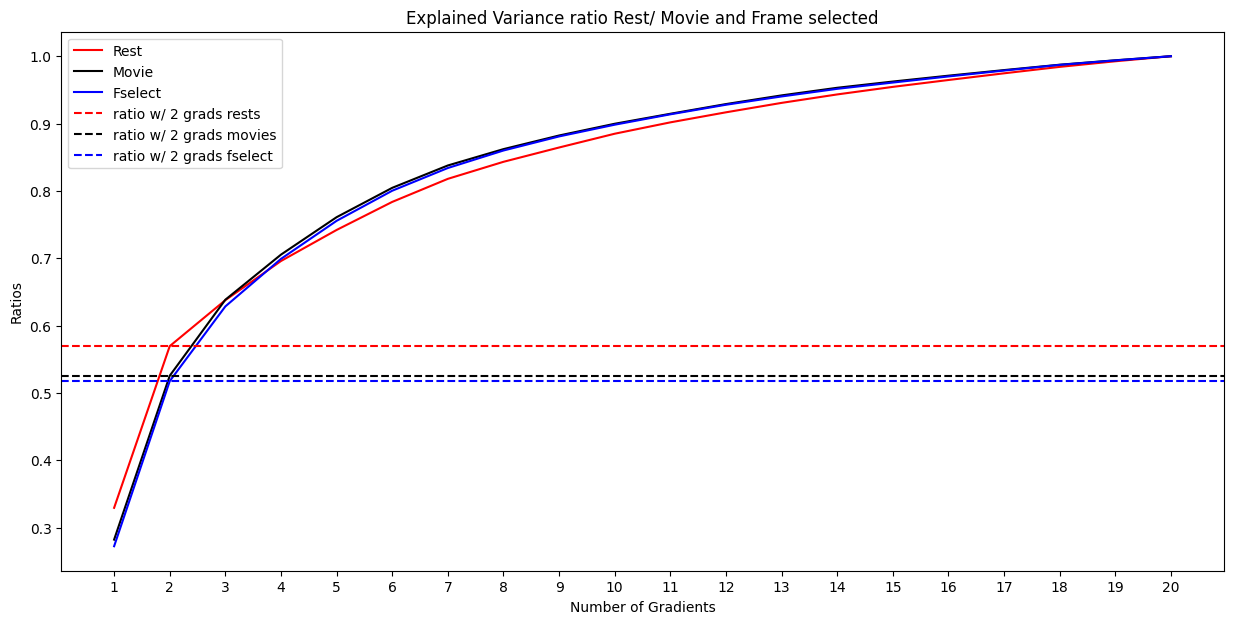

In [15]:
var_rests = rest_expvar/rest_expvar.sum()
var_movies = movies_expvar/movies_expvar.sum()
var_fselect = deepcopy(fselect_group_expvar[1][(75,100)])
var_fselect /= var_fselect.sum()

plt.figure(figsize=(15,7))

plt.plot(np.arange(1,21),np.cumsum(var_rests), label='Rest', c='r')
plt.plot(np.arange(1,21),np.cumsum(var_movies), label='Movie', c='k')
plt.plot(np.arange(1,21),np.cumsum(var_fselect), label='Fselect', c='b')

plt.axhline(y = np.cumsum(var_rests)[1], color = 'r', linestyle = '--', label='ratio w/ 2 grads rests')
plt.axhline(y = np.cumsum(var_movies)[1], color = 'k', linestyle = '--', label='ratio w/ 2 grads movies')
plt.axhline(y = np.cumsum(var_fselect)[1], color = 'b', linestyle = '--', label='ratio w/ 2 grads fselect')

plt.title('Explained Variance ratio Rest/ Movie and Frame selected')
plt.xlabel('Number of Gradients')
plt.ylabel('Ratios')

plt.xticks(np.arange(1,21))
plt.legend()
plt.show()

Second comparison Movie Vs different FS

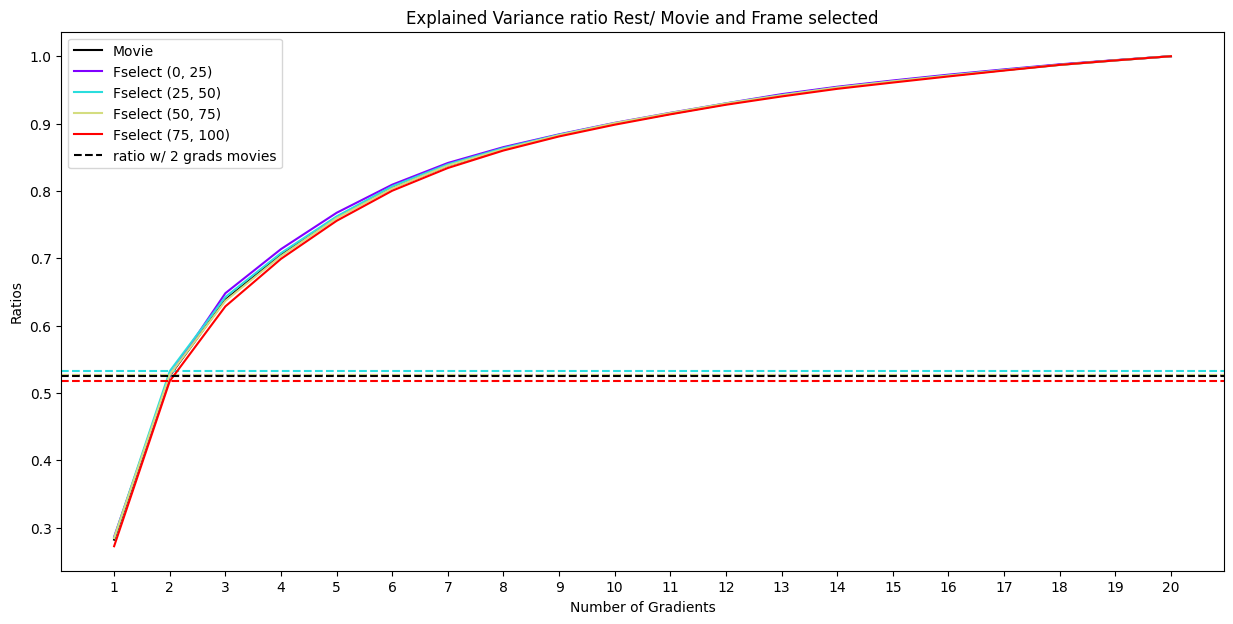

In [16]:
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, len(s25)))
var_movies = movies_expvar/movies_expvar.sum()

plt.figure(figsize=(15,7))

plt.plot(np.arange(1,21),np.cumsum(var_movies), label='Movie', c='k')


for idx,bound in enumerate(s25):
    var_fselect = deepcopy(fselect_group_expvar[1][bound])
    var_fselect /= var_fselect.sum()
    plt.plot(np.arange(1,21),np.cumsum(var_fselect), label='Fselect {}'.format(bound), c=color[idx])
    #plt.axhline(y = np.cumsum(var_fselect)[1], color = color[idx], linestyle = '--',
     #           label='ratio w/ 2 grads fselect {}'.format(bound))
    plt.axhline(y = np.cumsum(var_fselect)[1], color = color[idx], linestyle = '--')


plt.axhline(y = np.cumsum(var_movies)[1], color = 'k', linestyle = '--', label='ratio w/ 2 grads movies')


plt.title('Explained Variance ratio Rest/ Movie and Frame selected')
plt.xlabel('Number of Gradients')
plt.ylabel('Ratios')


plt.xticks(np.arange(1,21))
# plt.xlim(2,6)
# plt.ylim(0.5,0.8)
plt.legend()
plt.show()

#### Joint Plot of 1st and 2nd Gradient + 1st and 3rd Gradient (2D)

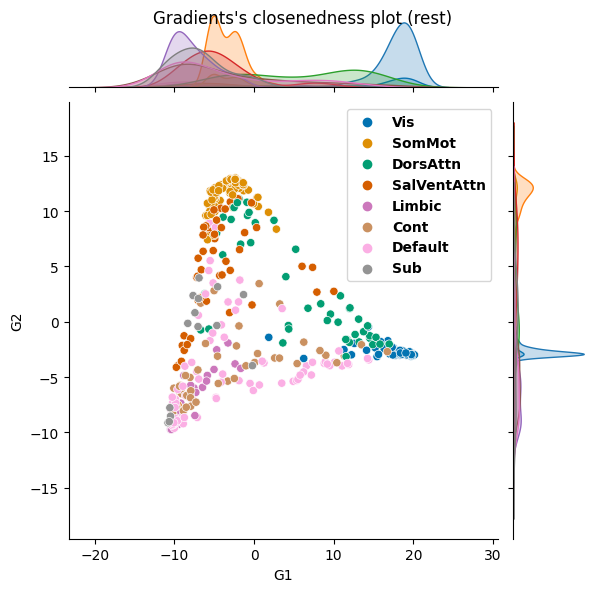

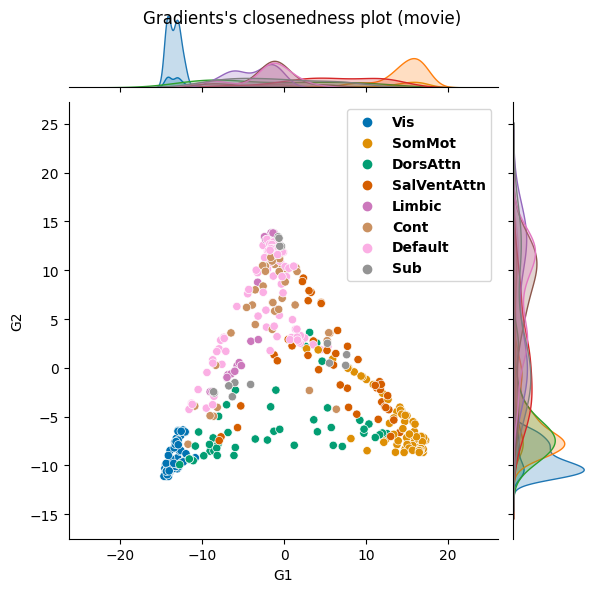

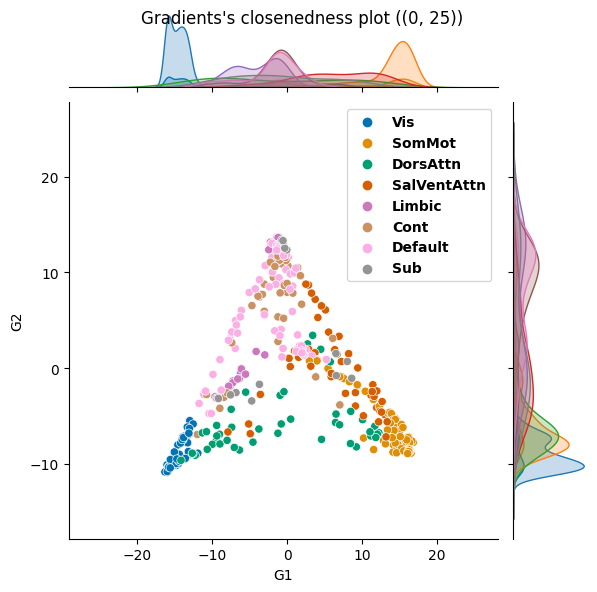

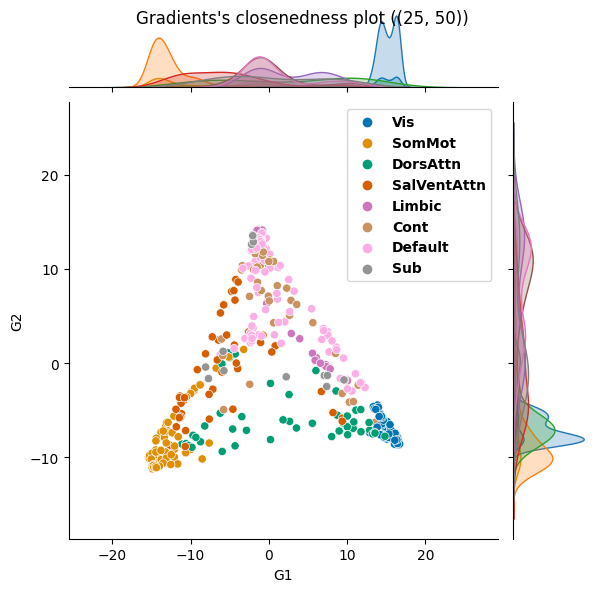

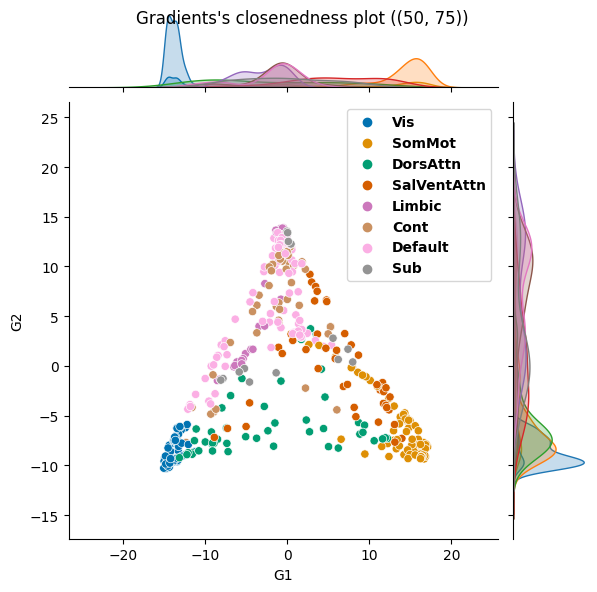

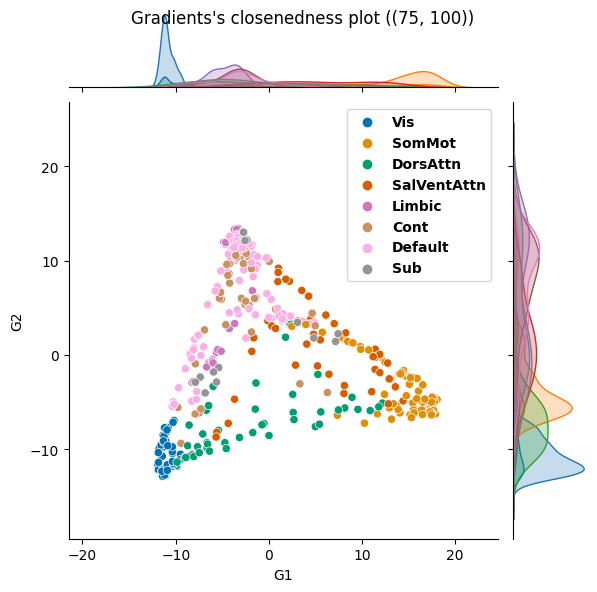

In [17]:
partial_region = load('./resources/region414yeo7.pkl')
coloring       = [partial_region[i] for i in range(414)]
pal            = sns.color_palette('colorblind', 8)

gs = [rest_grad, movies_grad]
gs += [fselect_group_gradients[1][s] for s in s25]

ts = ['rest', 'movie'] + s25
for i in range(len(gs)):
    # we keep exact same coloring method: same encoding
    tmp_df = {"G1":gs[i][:,0] , "G2": gs[i][:,1], "region": coloring}
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", hue="region", palette=pal)
    df = pd.DataFrame.from_dict(tmp_df)

    for k in df.region.unique():
        data = df[df.region == k]

        sns.kdeplot(x=data.G1, fill=True, label=k, ax=ax.ax_marg_x)
        sns.kdeplot(y=data.G2, fill=True, label=k, ax=ax.ax_marg_y)

    ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]))

    legend_properties = {'weight':'bold','size':10}
    ax.ax_joint.legend(prop=legend_properties,loc='upper right')

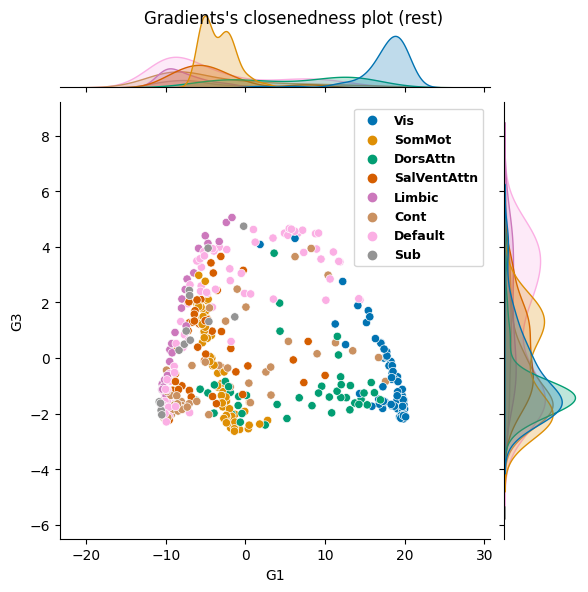

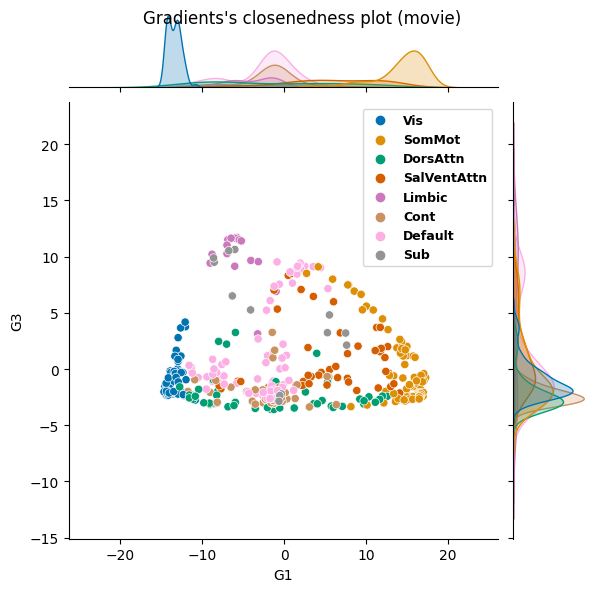

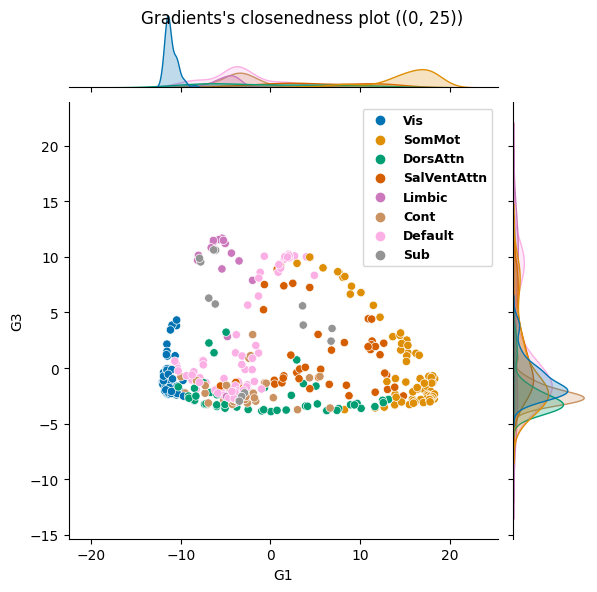

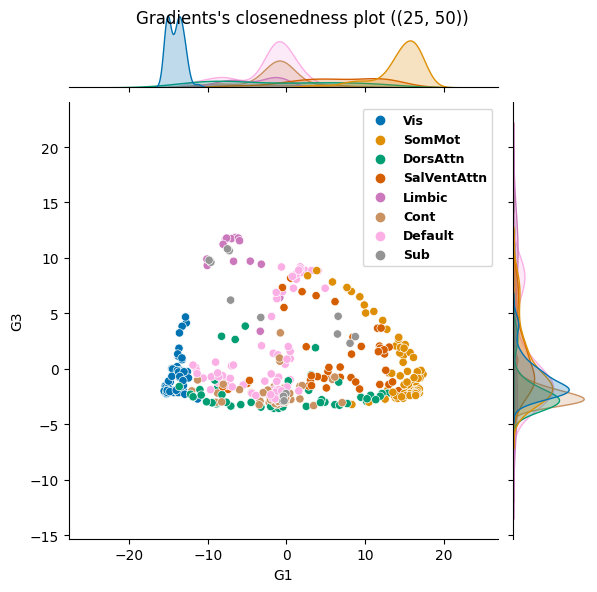

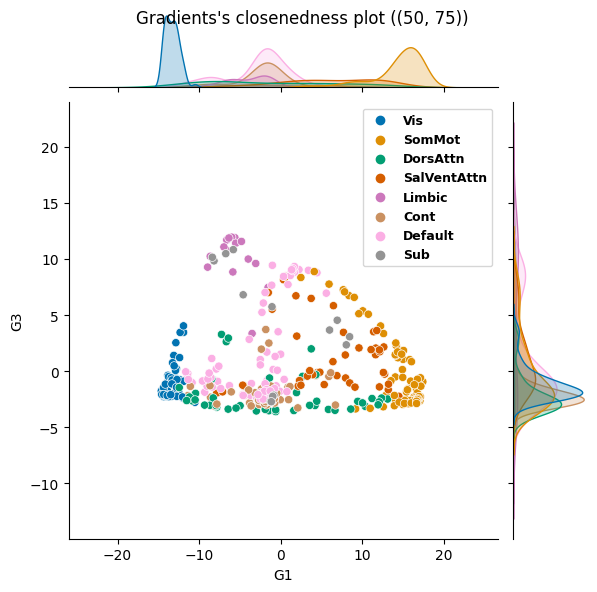

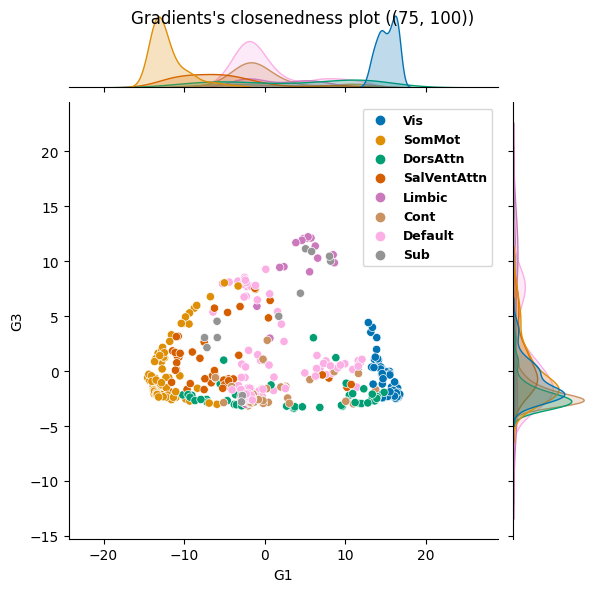

In [18]:
partial_region = load('./resources/region414yeo7.pkl')
coloring  = [partial_region[i] for i in range(414)]
pal       = sns.color_palette('colorblind', 8)

gs = [rest_grad, movies_grad]
gs += [fselect_group_gradients[2][s] for s in s25]

ts = ['rest', 'movie'] + s25
for i in range(len(gs)):
    # we keep exact same coloring method: same encoding
    tmp_df = {"G1":gs[i][:,0] , "G3": gs[i][:,2], "region": coloring}
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G3", hue="region", palette=pal)
    ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]))
    legend_properties = {'weight':'bold','size':9}
    ax.ax_joint.legend(prop=legend_properties,loc='upper right')

#### Visualization Gradients

cortical

In [ ]:
# Parcellation 400
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0
gs   = [g_rest400, g_movie400]
grad = [None] * 4
for i in range(2):
    for k in range(2):
        # map the gradient to the parcels
        grad[i*2+k] = map_to_labels(gs[i].gradients_[:, k], labeling, mask=mask, fill=np.nan)
#         gs[i].gradients_[:, k]

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='viridis_r',
                 color_bar=True, color_range=[(-1,1),(-1,1),(-1,1),(-1,1)], label_text=['Grad1-Rest', 'Grad2-Rest', 'Grad1-Movie', 'Grad2-Movie'], zoom=1.55, embed_nb=True, interactive=False,
                 transparent_bg=False)

subcortical

In [ ]:
from enigmatoolbox.plotting import plot_subcortical

with open('./data/labels/TC_sub14_labels.csv') as f:
    text = f.readlines()
    text = [t.strip() for t in text]

order = "left-accumbens, left-amygdala, left-caudate, left-hippocampus, left-pallidum, left-putamen, left-thalamus, right-accumbens, right-amygdala, right-caudate, right-hippocampus, right-pallidum, right-putamen, right-thalamus".split(',')
order = [' '.join(o.split('-')).strip() for o in order]
dataorder = [t.lower() for t in text]

orderidx = [order.index(o) for o in dataorder]

# "color-range" flag can be used if needed very useful instead of artificially
# Project the results on the surface brain
plot_subcortical(array_name=g_rest414.gradients_[400:,0][orderidx], ventricles=False, size=(800, 400),
                  cmap='viridis', color_bar=True,embed_nb=True, label_text=['rest sub'], interactive=False,transparent_bg=False)
plot_subcortical(array_name=g_movie414.gradients_[400:,0][orderidx], ventricles=False, size=(800, 400),
                  cmap='viridis', color_bar=True,embed_nb=True, label_text=['movie sub'], interactive=False,transparent_bg=False)

#### Cross conditions correlations

In [19]:
all_grads = [rest_grad, movies_grad] + [fselect_group_gradients[1][bound] for bound in s25]
aligned, _, s = procrustes_align(all_grads)

In [20]:
# Film vs rest
cross_cond = np.zeros((aligned.shape[2],aligned.shape[2]))
cond1 = aligned[0]
cond2 = aligned[1]
for k in range(cond1.shape[1]):
    for j in range(cond2.shape[1]):
        cross_cond[k,j] = pearson_correlation(cond1[:,k], cond2[:,j])

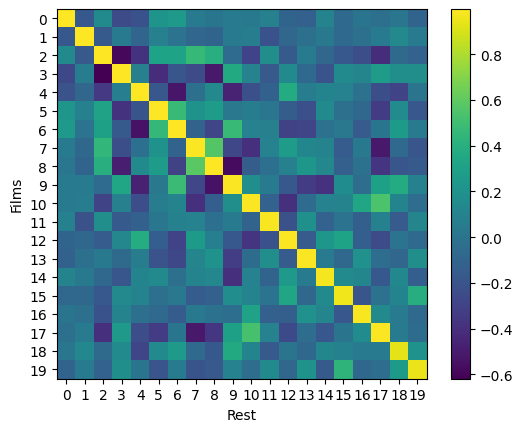

In [26]:
fig, ax = plt.subplots()

im = ax.imshow(cross_cond)
ax.set_xticks(np.arange(20))
ax.set_yticks(np.arange(20))
ax.set_ylabel('Films')
ax.set_xlabel('Rest')
plt.colorbar(im)

plt.show()

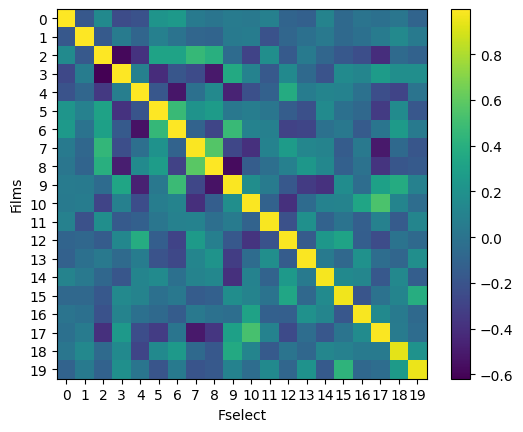

In [28]:
# Film vs FS1, Film vs FS2, Film vs FS3
# Film vs rest
cross_cond = np.zeros((aligned.shape[2],aligned.shape[2]))
cond1 = aligned[1]
cond2 = aligned[2]
for k in range(cond1.shape[1]):
    for j in range(cond2.shape[1]):
        cross_cond[k,j] = pearson_correlation(cond1[:,k], cond2[:,j])
        
fig, ax = plt.subplots()

im = ax.imshow(cross_cond)
ax.set_xticks(np.arange(20))
ax.set_yticks(np.arange(20))
ax.set_ylabel('Films')
ax.set_xlabel('Fselect')
plt.colorbar(im)
plt.show()

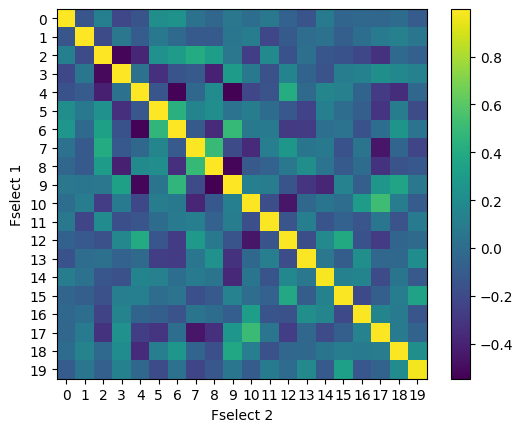

In [30]:
# Film vs FS1, Film vs FS2, Film vs FS3
# Film vs rest
cross_cond = np.zeros((aligned.shape[2],aligned.shape[2]))
cond1 = aligned[1]
cond2 = aligned[-1]
for k in range(cond1.shape[1]):
    for j in range(cond2.shape[1]):
        cross_cond[k,j] = pearson_correlation(cond1[:,k], cond2[:,j])
        
fig, ax = plt.subplots()

im = ax.imshow(cross_cond)
ax.set_xticks(np.arange(20))
ax.set_yticks(np.arange(20))
ax.set_ylabel('Fselect 1')
ax.set_xlabel('Fselect 2')
plt.colorbar(im)
plt.show()

#### Distance on manifold gradients display